In [7]:
!pip install talos

In [0]:
run predict_tunning.py

In [9]:
import datetime
gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
'''
Vars
'''

nr_features = 13
timesteps = 24
multisteps = 24
epochs = 65
batch_size = 24
verbose = 0
patience = 15
n_splits = 5
now = datetime.datetime.now()

# Files
file_path = 'AvenidaAliados.csv'
#file_path = 'AvenidaGustavoEiffel.csv'
#file_path = 'RuaCondeVizela.csv'
#file_path = 'RuaNovaAlfandega.csv'

# Load data
df = load_data(file_path)

# Prepare data
df_until_now, scaler, df_temp, drop_columns = prepare_data(df)

df_copy = df.copy()
df_all = df_copy.drop(columns=drop_columns)
df_all = fill_missing(df_all )

# Num features to use
print("Nr Features:", df_until_now.shape[1])
nr_features = df_until_now.shape[1]
columns = df_until_now.columns

# To supervisioned
X, Y = to_supervised(df_until_now, timesteps, multisteps, nr_features)

print("Shape X:", X.shape)
print("Shape Y:", Y.shape)

current_speed            0
free_flow_speed          0
current_travel_time      0
free_flow_travel_time    0
time_diff                0
speed_diff               0
Hour                     0
Day of month             0
Month (number)           0
delay_in_seconds         0
humidity                 0
length_in_meters         0
temperature              0
dtype: int64
Nr Features: 13
Shape X: (8735, 24, 13)
Shape Y: (8735, 1)


In [16]:
# Tunnig
p = {
  'first_neuron': [32, 64],
  'batch_size': [32, 64],
  'epochs': [50, 100],
  'dropout': [0.2, 0.4],
  'optimizer': ['Adam', 'Nadam', 'RMSprop'],
  'losses': ['mse', 'mae'],
  'activation':['relu', 'elu', 'tanh'],
  'last_activation': ['tanh', 'softmax', 'linear'],
}

scan_object = talos.Scan(X, Y, 
                         model=tunnig, 
                         params=p, 
                         experiment_name='speed_diff', 
                         fraction_limit=0.1)


  0%|          | 0/86 [00:00<?, ?it/s]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100%|██████████| 86/86 [9:09:23<00:00, 383.30s/it]


In [24]:
# accessing the results data frame
scan_object.data.head(10)

,round_epochs,loss,mean_absolute_error,val_loss,val_mean_absolute_error,activation,batch_size,dropout,epochs,first_neuron,last_activation,losses,optimizer
0,50,0.140313,0.140313,0.154057,0.154057,relu,32,0.2,50,64,tanh,mae,Nadam
1,50,0.161460,0.161460,0.166156,0.166156,relu,64,0.4,50,64,linear,mae,Adam
2,100,0.035894,0.133015,0.059558,0.166738,relu,64,0.2,100,64,tanh,mse,RMSprop
3,100,3.127638,1.734642,3.125118,1.733791,tanh,64,0.2,100,64,softmax,mse,RMSprop
4,50,0.265358,0.265358,0.266209,0.266209,relu,64,0.2,50,64,tanh,mae,Nadam
5,50,0.147093,0.147094,0.158903,0.158903,tanh,64,0.2,50,64,tanh,mae,Nadam
6,50,1.734642,1.734642,1.733791,1.733791,relu,64,0.4,50,64,softmax,mae,Nadam
7,100,1.734642,1.734642,1.733791,1.733791,relu,32,0.4,100,32,softmax,mae,RMSprop
8,100,0.265358,0.265358,0.266209,0.266209,relu,32,0.2,100,64,tanh,mae,Adam
9,50,0.049852,0.157142,0.059258,0.173070,elu,32,0.4,50,64,tanh,mse,Nadam


In [25]:
# accessing epoch entropy values for each round
scan_object.learning_entropy

,loss,mean_absolute_error
0,1.203004e-03,1.202980e-03
1,1.188245e-03,1.188247e-03
2,1.380664e-02,2.982559e-03
3,5.278551e-16,-1.471489e-07
4,1.522784e-04,1.522856e-04
...,...,...
81,3.340494e-03,3.340364e-03
82,3.004330e-03,6.189290e-04
83,1.715873e-03,1.001684e-03
84,-2.664044e-16,-2.989545e-07


In [26]:
# access the summary details
scan_object.details

experiment_name              speed_diff
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                 0.2
reduction_metric                val_acc
complete_time            05/13/20/20:46
x_shape                  (8735, 24, 13)
y_shape                       (8735, 1)
dtype: object

In [27]:
# accessing the saved models
scan_object.saved_models

['{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "LSTM", "config": {"name": "lstm", "trainable": true, "batch_input_shape": [null, 24, 13], "dtype": "float32", "return_sequences": true, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "time_major": false, "units": 64, "activation": "relu", "recurrent_activation": "hard_sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null, "dtype": "float32"}}, "recurrent_initializer": {"class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null, "dtype": "float32"}}, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "unit_forget_bias": true, "kernel_regularizer": null, "recurrent_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "recurrent_constraint": null, "bias_constraint": null, "dropout": 0.0, "recurrent_dropout": 0.0, "implementation": 1}

In [28]:
# accessing the saved weights for models
scan_object.saved_weights

[[array([[ 0.17559169, -0.09562933, -0.10159072, ...,  0.6107103 ,
          -0.03342099, -0.31572437],
         [ 0.21810447, -0.06639235,  0.3564154 , ..., -0.07443798,
          -0.09674114, -0.08462957],
         [-0.193966  ,  0.01088173, -0.17796163, ..., -0.07832985,
          -0.166305  ,  0.03685516],
         ...,
         [-0.04265683,  0.1826376 ,  0.5476913 , ..., -0.00762089,
           0.19564445, -0.03611084],
         [-0.06028048, -0.24006748, -0.46658325, ...,  0.07181551,
           0.10525233, -0.01538557],
         [-0.23266375, -0.01232347, -0.27594253, ...,  0.08828238,
          -0.13604385,  0.02793052]], dtype=float32),
  array([[-0.07524107,  0.00478087,  0.287736  , ..., -0.03851371,
          -0.08107145, -0.03718323],
         [ 0.1356526 , -0.02797959, -0.09353588, ..., -0.03327153,
           0.01564059, -0.3231646 ],
         [ 0.137059  ,  0.10978861, -0.00386869, ..., -0.09837184,
           0.2636237 , -0.04016657],
         ...,
         [ 0.113476

In [0]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object)

In [30]:
# access the dataframe with the results
analyze_object.data

,round_epochs,loss,mean_absolute_error,val_loss,val_mean_absolute_error,activation,batch_size,dropout,epochs,first_neuron,last_activation,losses,optimizer
0,50,0.140313,0.140313,0.154057,0.154057,relu,32,0.2,50,64,tanh,mae,Nadam
1,50,0.161460,0.161460,0.166156,0.166156,relu,64,0.4,50,64,linear,mae,Adam
2,100,0.035894,0.133015,0.059558,0.166738,relu,64,0.2,100,64,tanh,mse,RMSprop
3,100,3.127638,1.734642,3.125118,1.733791,tanh,64,0.2,100,64,softmax,mse,RMSprop
4,50,0.265358,0.265358,0.266209,0.266209,relu,64,0.2,50,64,tanh,mae,Nadam
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,50,0.165029,0.165029,0.158365,0.158365,relu,32,0.4,50,32,linear,mae,Nadam
82,50,0.054829,0.164356,0.056146,0.168259,elu,64,0.4,50,32,tanh,mse,Adam
83,50,0.055384,0.169509,0.056533,0.170549,elu,64,0.2,50,32,linear,mse,RMSprop
84,100,1.734642,1.734641,1.733791,1.733791,tanh,32,0.4,100,64,softmax,mae,Nadam


In [31]:
# get the number of rounds in the Scan
analyze_object.rounds()

86

In [32]:
# get the highest result for any metric
analyze_object.high('val_mean_absolute_error')

1.733791470527649

In [33]:
# get the round with the best result
analyze_object.rounds2high('val_mean_absolute_error')

3

In [35]:
# get the best paramaters
analyze_object.best_params('val_mean_absolute_error', ['mean_absolute_error', 'loss', 'val_loss'])

array([[0.2, 32, 100, 100, 'relu', 'softmax', 'RMSprop', 32, 'mse', 0],
       [0.2, 64, 100, 100, 'tanh', 'softmax', 'RMSprop', 64, 'mse', 1],
       [0.4, 32, 100, 100, 'relu', 'softmax', 'RMSprop', 32, 'mae', 2],
       [0.4, 64, 50, 50, 'relu', 'softmax', 'Nadam', 32, 'mse', 3],
       [0.2, 64, 100, 100, 'elu', 'softmax', 'Adam', 64, 'mse', 4],
       [0.4, 64, 50, 50, 'tanh', 'softmax', 'RMSprop', 32, 'mse', 5],
       [0.4, 32, 100, 100, 'relu', 'softmax', 'Adam', 32, 'mse', 6],
       [0.2, 64, 100, 100, 'elu', 'softmax', 'Nadam', 64, 'mse', 7],
       [0.4, 32, 100, 100, 'tanh', 'softmax', 'RMSprop', 32, 'mae', 8],
       [0.2, 64, 50, 50, 'tanh', 'softmax', 'Nadam', 64, 'mae', 9]],
      dtype=object)

In [36]:
# get correlation for hyperparameters against a metric
analyze_object.correlate('val_loss', ['mae', 'loss', 'val_loss'])

round_epochs               0.147619
mean_absolute_error        0.933580
val_mean_absolute_error    0.933536
batch_size                -0.054586
dropout                   -0.130343
epochs                     0.147619
first_neuron              -0.101477
Name: val_loss, dtype: float64

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


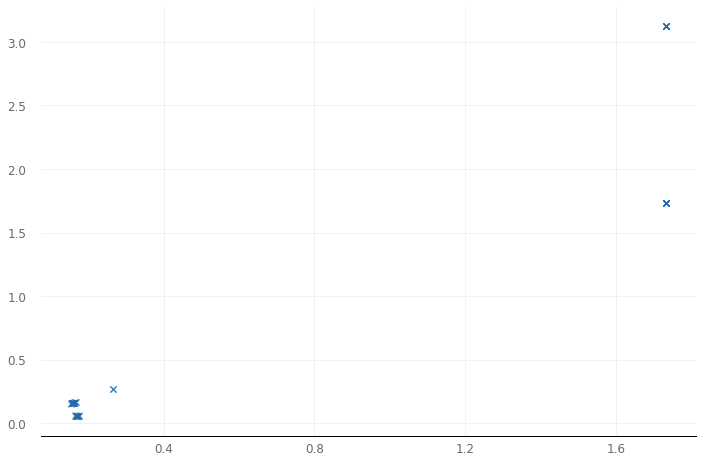

In [37]:
# a regression plot for two dimensions 
analyze_object.plot_regs('val_mean_absolute_error', 'val_loss')

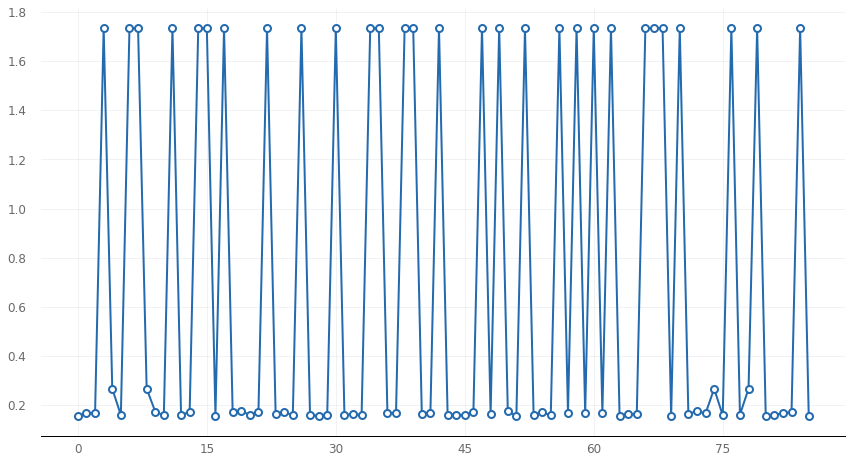

In [38]:
# line plot
analyze_object.plot_line('val_mean_absolute_error')

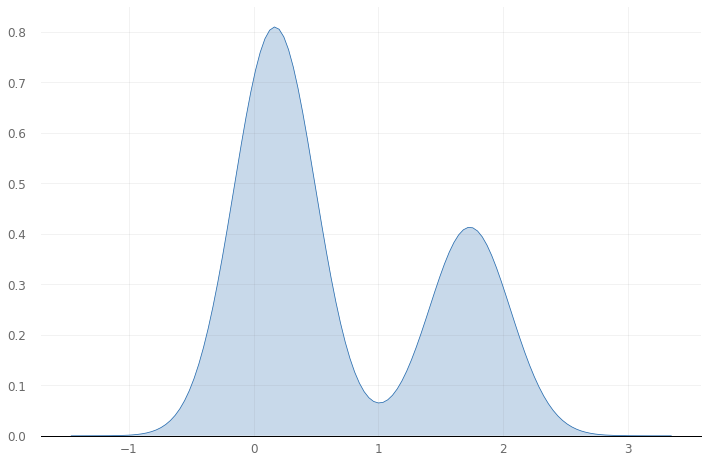

In [39]:
# up to two dimensional kernel density estimator
analyze_object.plot_kde('val_mean_absolute_error')

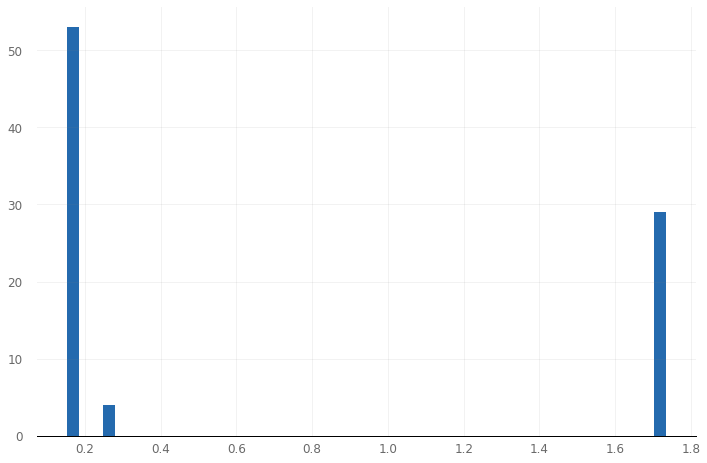

In [40]:
# a simple histogram
analyze_object.plot_hist('val_mean_absolute_error', bins=50)

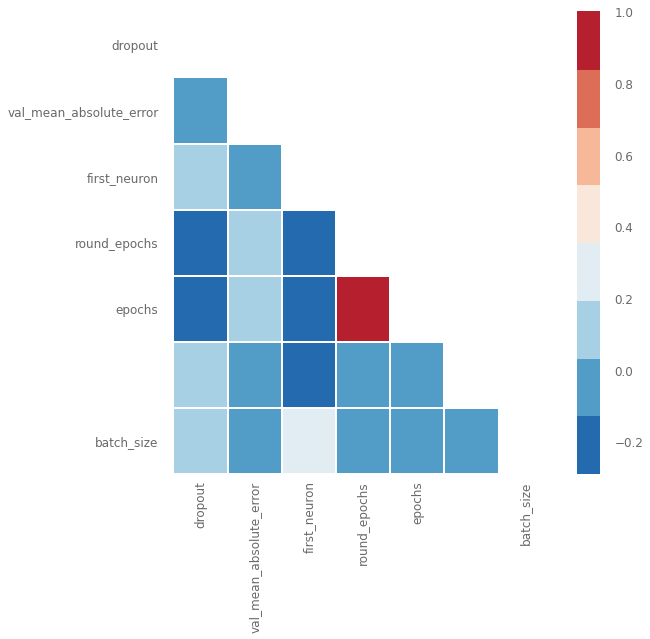

In [41]:
# heatmap correlation
analyze_object.plot_corr('val_mean_absolute_error', ['mean_absolute_error', 'loss', 'val_loss'])